## Библиотеки

In [ ]:
#Импорт библиотек

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import zipfile

import time
from IPython import display
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten

## Загружаем изображения города

In [ ]:
#Если работаем через google disk
#Подключимся к диску с данными
from google.colab import drive
drive.mount('/content/gdrive')
dir_path = '/content/gdrive/MyDrive/City_gen'

Mounted at /content/gdrive


In [ ]:
#Архив с данными
zip_file = dir_path + '/Houses.zip'

#Распакуем
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
#Директория с датасетом
base_dir ='/content/H/'

## Подготовка датасета

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 128

In [ ]:
data_gener = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                            #  rotation_range=30, 
                                                             shear_range=0.2, 
                                                             zoom_range=0.2,
                                                             horizontal_flip=True,
                                                             fill_mode="nearest")

image_generator = data_gener.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory=base_dir, 
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode=None)

Found 598 images belonging to 1 classes.


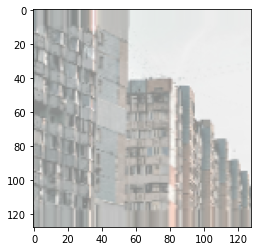

In [ ]:
sample = next(image_generator)
plt.imshow((sample[0] + 1.) / 2)

## Модель генерации изображения

Параметры



---



In [ ]:
#Размер изображения
IMG_SIZE = 128
#Количество каналов
n_channels = 3


#Количество upsampling
n_upsamples = int(np.log2(IMG_SIZE / 8))
#Количество downsampling
n_downsamples = int(np.log2(IMG_SIZE / 8))


#loss и optimizer
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)


#Латентный вектор
z_vector = 100
#Размер фильтров сверток генератора
gen_size = 128 
#Размер фильтров сверток дискриминатора
dis_size = 128

Генератор



---



In [ ]:
#Создадим модель генератора
generator_img_model = tf.keras.Sequential([
    #Сделаем вектор трехмерным
    tf.keras.layers.Reshape((1, 1, z_vector), input_shape=(z_vector, )),
    
    #Свертка
    tf.keras.layers.Conv2DTranspose(gen_size * 2**n_upsamples, 
                                    kernel_size=4, 
                                    use_bias=False, 
                                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.02)),
    #Нормализация
    tf.keras.layers.BatchNormalization(),
    #Активация
    tf.keras.layers.LeakyReLU()
    ])

#Сделаем необходимое количество upsampling 
for i in range(n_upsamples):
  generator_img_model.add(UpSampling2D()) # увеличиваем картинку
  #После каждого upsampling добавим Conv + BatchNorm + LeakyReLu
  generator_img_model_1 = tf.keras.Sequential([
      tf.keras.layers.Conv2D(gen_size * 2**n_upsamples // 2**(i+1), 
                             kernel_size=4, 
                             padding='same', 
                             use_bias=False, 
                             kernel_initializer = RandomNormal(mean=0.0, stddev=0.02),
                             strides=(1, 1)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU()
      ])
  generator_img_model.add(generator_img_model_1)



generator_img_model.add(UpSampling2D())

generator_img_model.add(Conv2D(n_channels,
                               kernel_size=4, 
                               strides=(1, 1),
                               activation='tanh', 
                               padding='same', 
                               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))

In [ ]:
#Функция потерь генератора
def gener_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Загрузить веса модели генератора
generator_img_model.load_weights('/content/gdrive/MyDrive/City_gen/panel_house_10')

Дискриминатор



---



In [ ]:
#Создадим модель дискриминатора
discriminator_img_model = tf.keras.Sequential([
    #Входной слой
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, n_channels)),
    tf.keras.layers.Conv2D(dis_size, 
                           kernel_size=4, 
                           padding='same',
                           use_bias=False, 
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02),
                           strides=(2, 2)),
    #Нормализация
    tf.keras.layers.BatchNormalization(),
    #Активация
    tf.keras.layers.LeakyReLU()
    ])

#Сделаем необходимое количество downsampling 
for i in range(n_downsamples):
  discriminator_img_model_1 = tf.keras.Sequential([
      tf.keras.layers.Conv2D(dis_size * (2**(i+1)), 
                             kernel_size=4, 
                             padding='same',
                             use_bias=False, 
                             kernel_initializer = RandomNormal(mean=0.0, stddev=0.02),
                             strides=(2, 2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU()
      ])
  discriminator_img_model.add(discriminator_img_model_1)


discriminator_img_model.add(Conv2D(1,
                 kernel_size=4, 
                 kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), 
                 use_bias=False))
discriminator_img_model.add(Flatten())

In [ ]:
#Веса дискрименатора
discriminator_img_model.load_weights('/content/gdrive/MyDrive/City_gen/discr_panel_house_6')

In [ ]:
#Функция потерь дискриминатора
def dis_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

Цикл обучения



---



In [ ]:
#Построим цикл обучения
disc_loss_hist = []
gen_loss_hist = []


def train_step(images):
  noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), z_vector])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator_img_model(noise, training=True)
    
    real_output = discriminator_img_model(images, training=True)
    fake_output = discriminator_img_model(generated_images, training=True)
    
    gen_loss = gener_loss(fake_output)
    disc_loss = dis_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_img_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_img_model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients_of_generator, generator_img_model.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_img_model.trainable_variables))
    return gen_loss, disc_loss, generated_images

    
def train(dataset, num_iters=2000, show_every=25):
  
  start = time.time()
  iters = 0
  for image_batch in dataset:
    print('.', end='')
    gen_loss, disc_loss, gen_image = train_step(image_batch)
    gen_image = 0.5 * gen_image + 0.5

    disc_loss_hist.append(disc_loss.numpy())
    gen_loss_hist.append(gen_loss.numpy())
    
    if iters % show_every == 0:
      display.clear_output(wait=True)
      plt.figure()
      plt.plot(disc_loss_hist, label="Discriminator loss")
      plt.plot(gen_loss_hist, label="Generator loss")
      plt.legend(loc="best")
      plt.figure()

      plt.imshow(gen_image[0])
      
      print(f"\n{iters}/{num_iters}")
      print(f'Time elapsed from start {time.time() - start} sec')
      
    iters += 1
    if iters > num_iters:
      print(f'Finished. Time elapsed from start {time.time() - start} sec')
      return

Обучение модели

##С дискриминатором

Итерация 1 (+5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



2000/2000
Time elapsed from start 9919.57279586792 sec
Finished. Time elapsed from start 9919.57281923294 sec


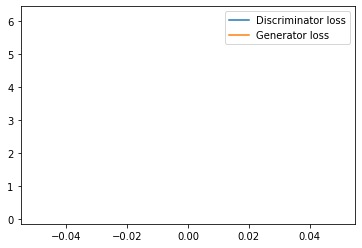

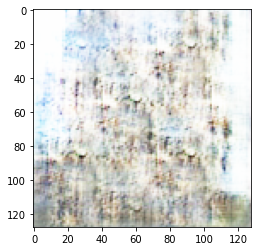

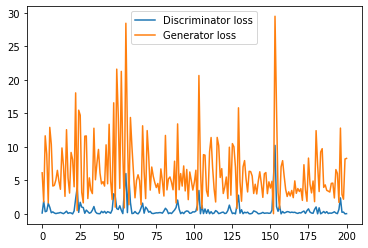

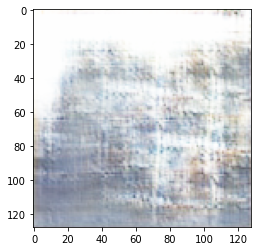

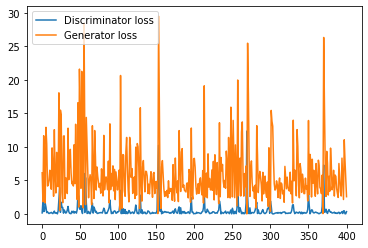

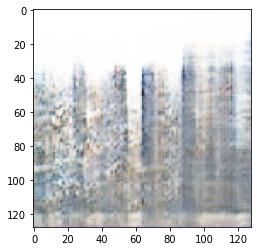

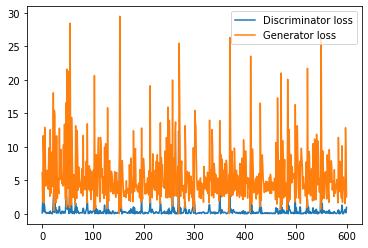

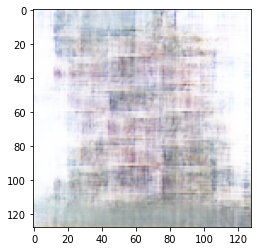

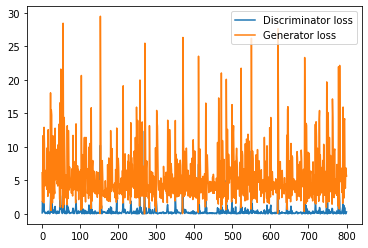

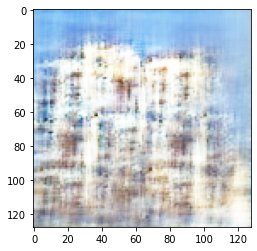

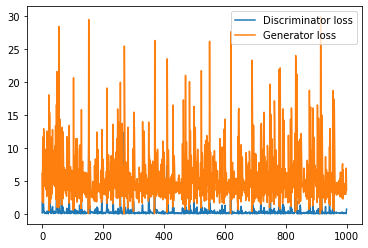

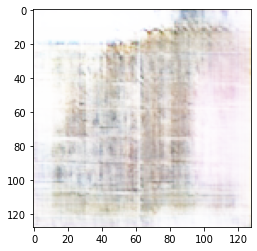

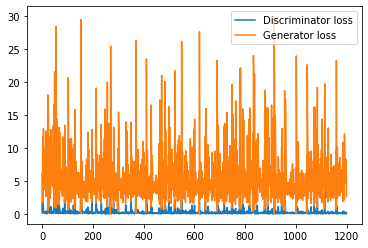

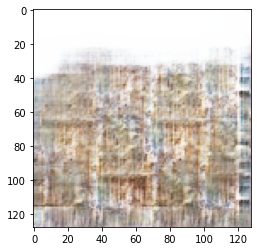

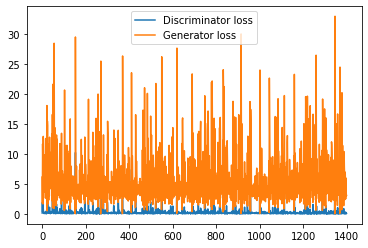

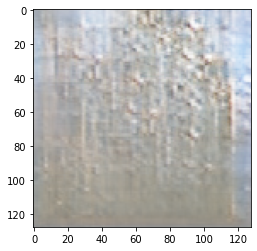

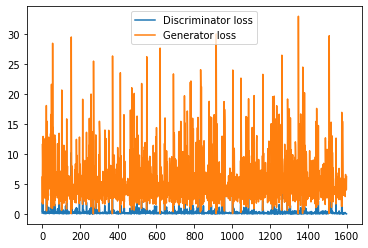

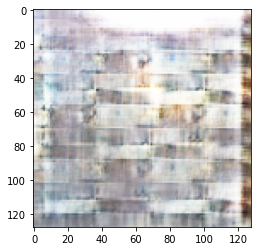

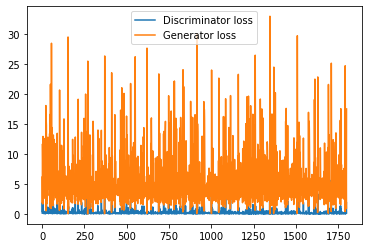

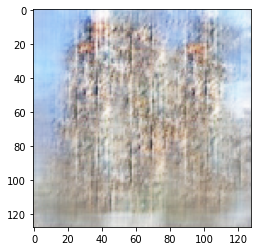

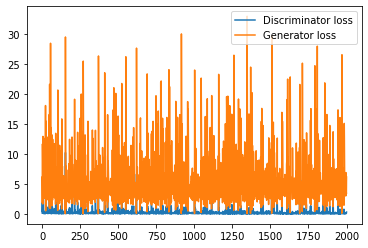

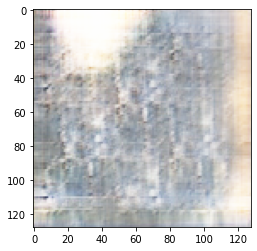

In [ ]:
train(image_generator, 2000, 200)

Итерация 2 (+5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



2000/2000
Time elapsed from start 9993.785130262375 sec
Finished. Time elapsed from start 9993.78516459465 sec


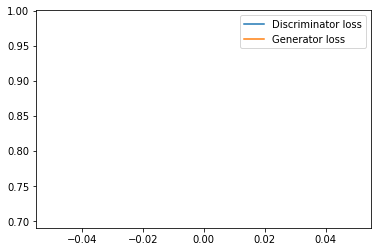

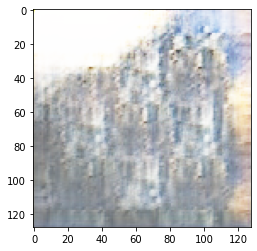

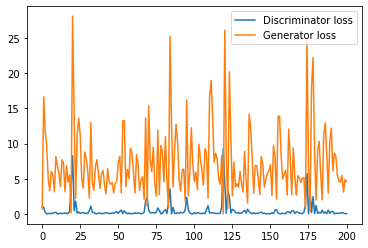

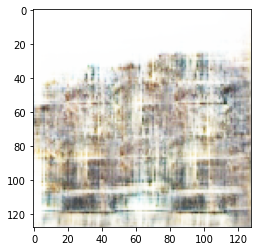

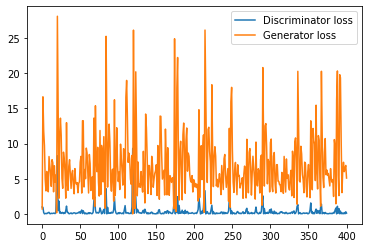

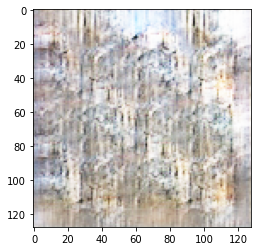

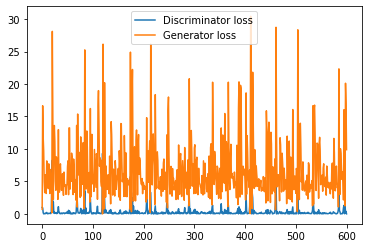

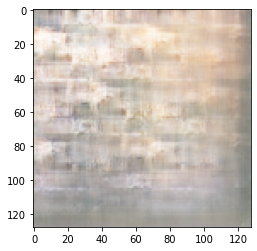

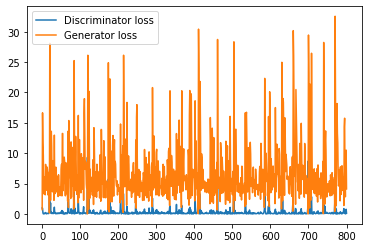

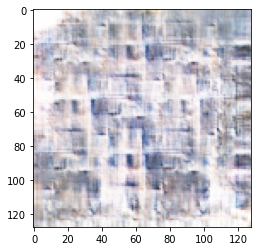

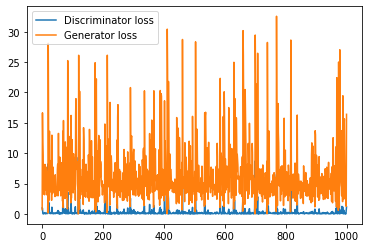

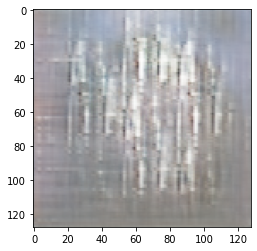

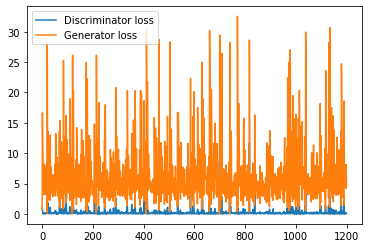

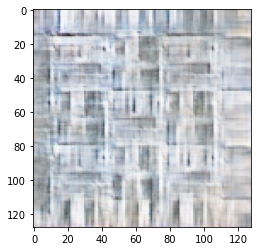

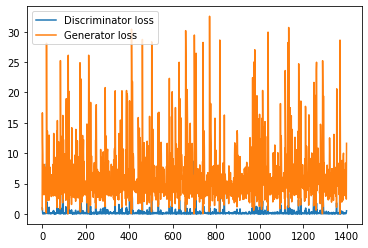

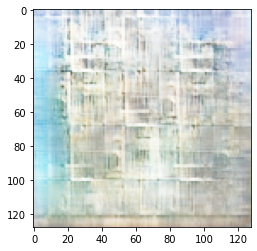

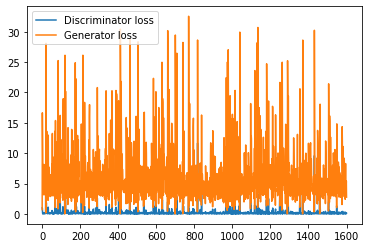

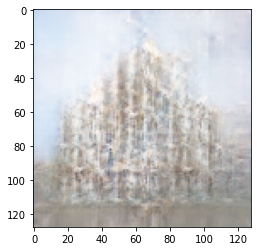

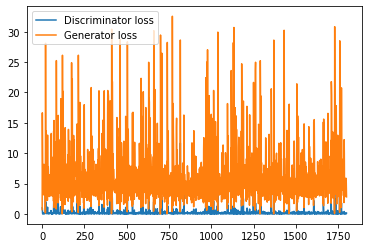

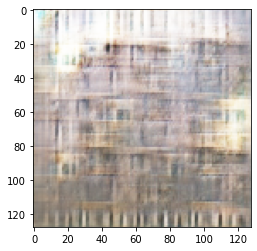

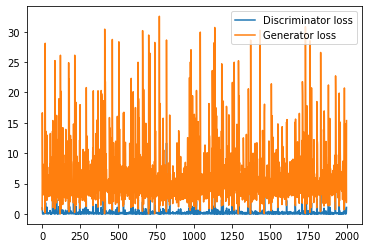

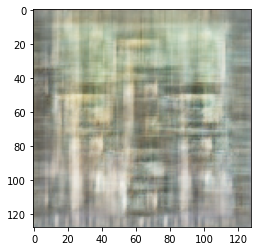

In [ ]:
train(image_generator, 2000, 200)

Сохранить веса моделей

Итерация 3 (+5)


1400/1400
Time elapsed from start 6708.33120059967 sec
Finished. Time elapsed from start 6708.331227302551 sec


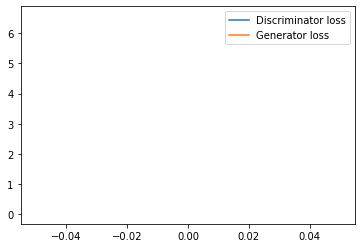

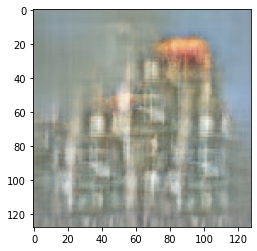

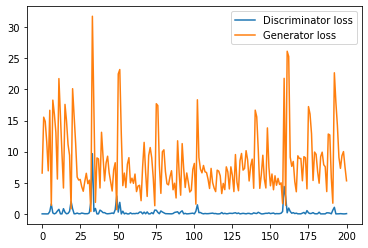

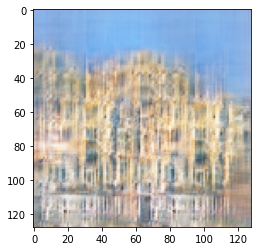

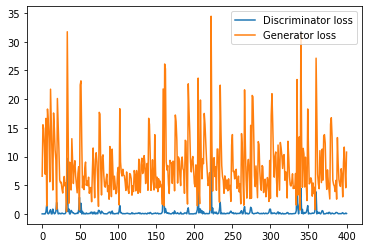

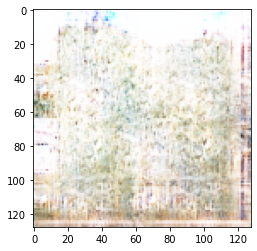

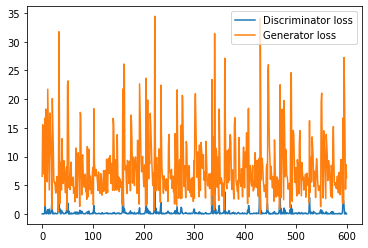

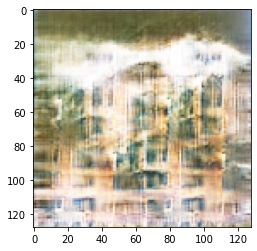

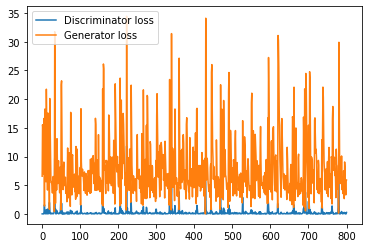

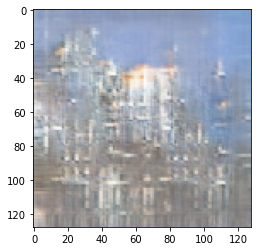

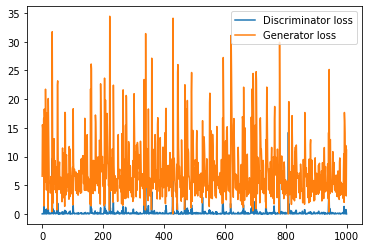

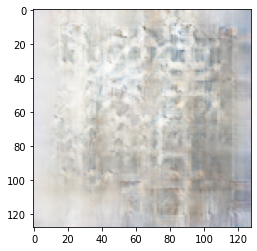

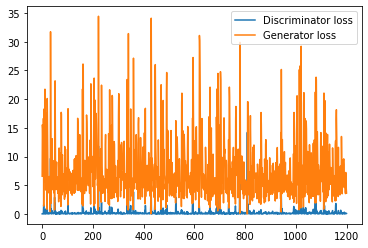

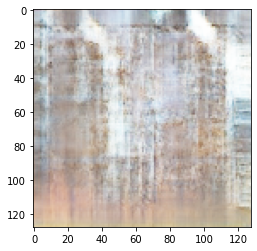

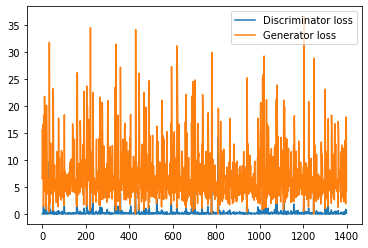

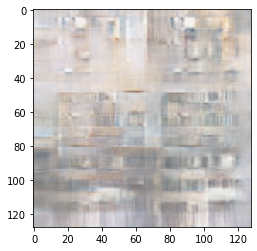

In [ ]:
train(image_generator, 1400, 200)

Итерация 4 (+5)


1400/1400
Time elapsed from start 6717.77056145668 sec
Finished. Time elapsed from start 6717.770611286163 sec


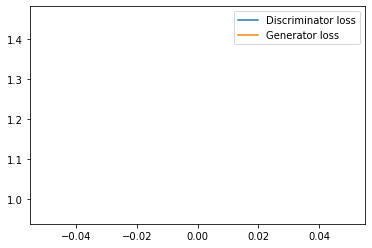

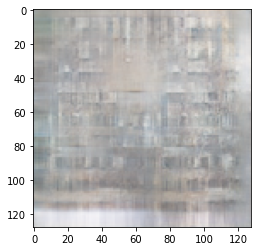

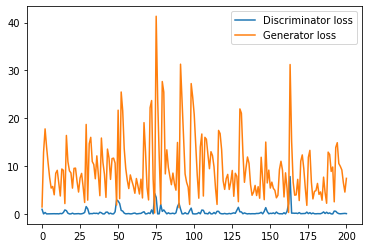

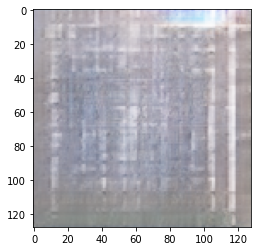

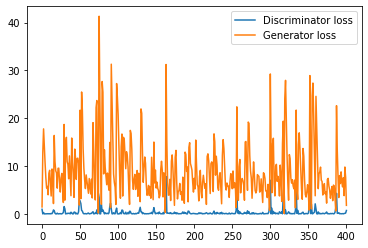

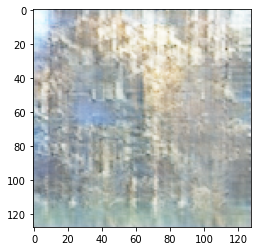

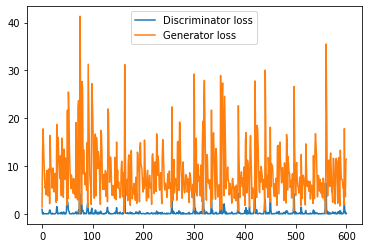

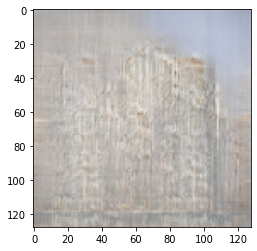

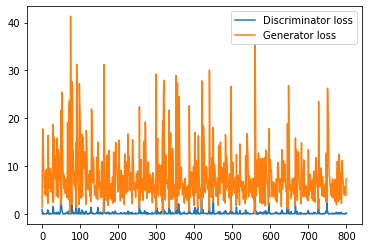

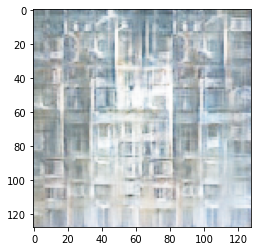

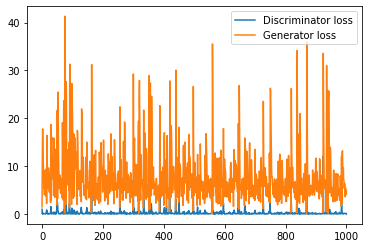

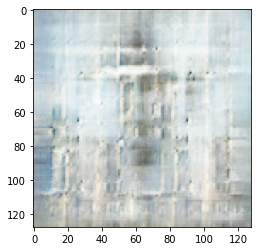

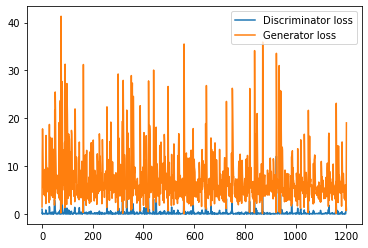

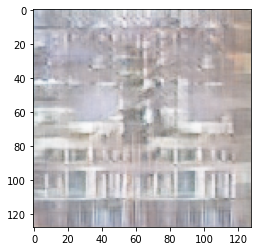

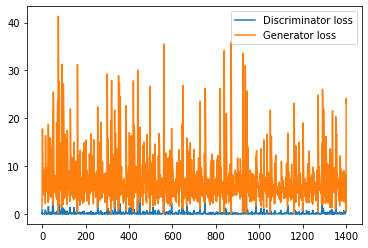

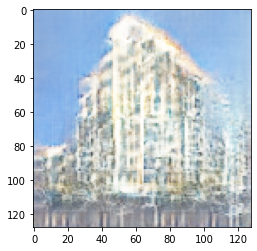

In [ ]:
train(image_generator, 1400, 200)

Итерация 5 (+5)


1400/1400
Time elapsed from start 6610.6516745090485 sec
Finished. Time elapsed from start 6610.651705980301 sec


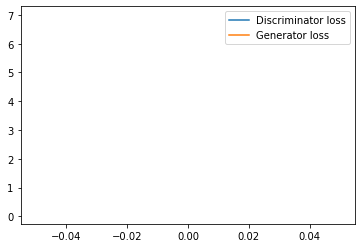

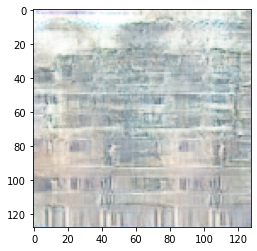

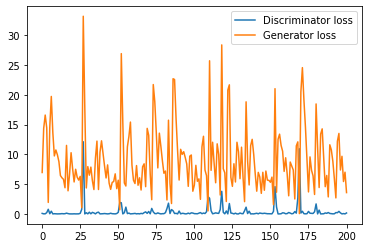

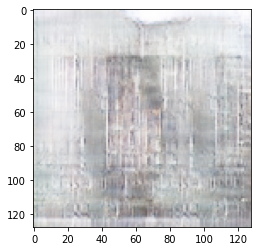

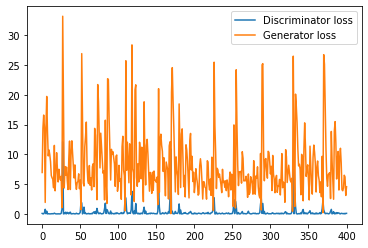

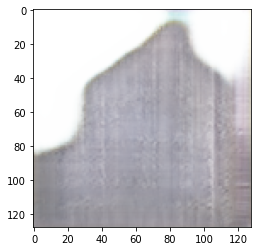

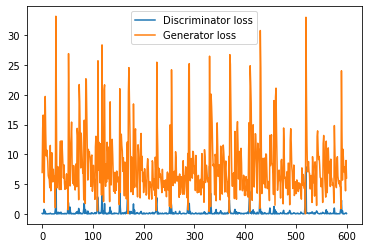

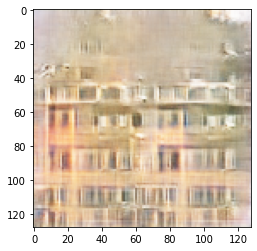

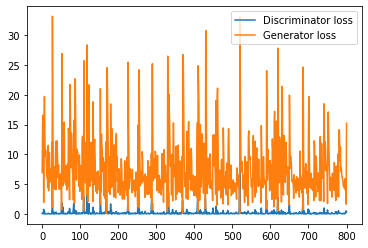

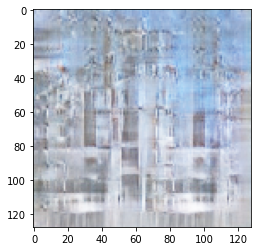

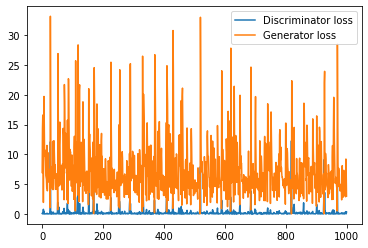

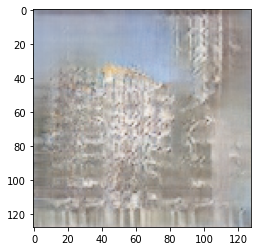

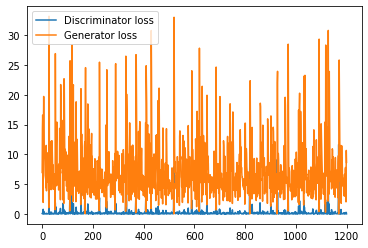

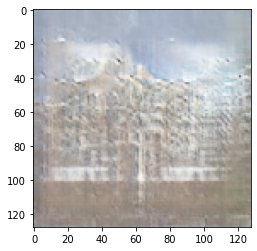

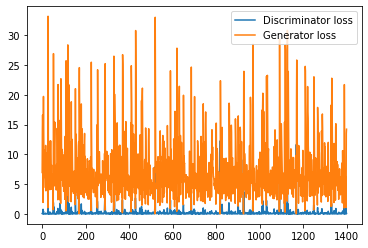

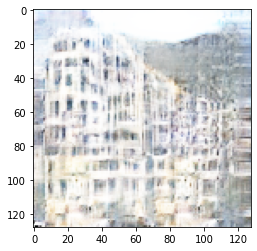

In [ ]:
train(image_generator, 1400, 200)

Итерация 6 (+5)


1400/1400
Time elapsed from start 6796.038596868515 sec
Finished. Time elapsed from start 6796.038631916046 sec


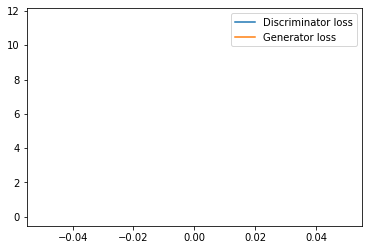

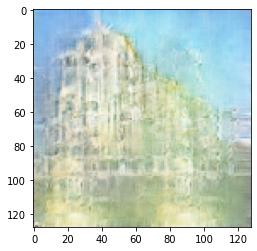

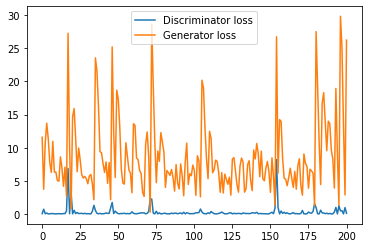

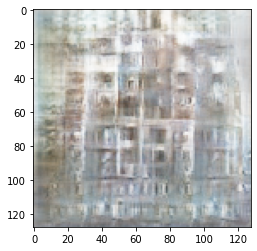

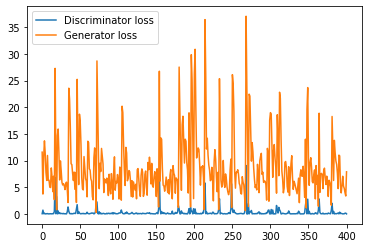

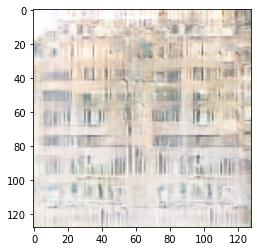

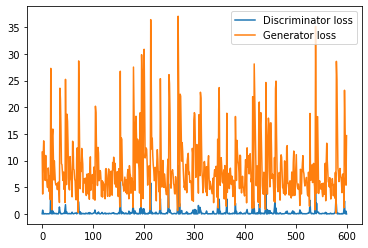

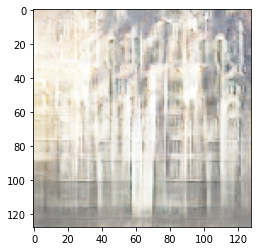

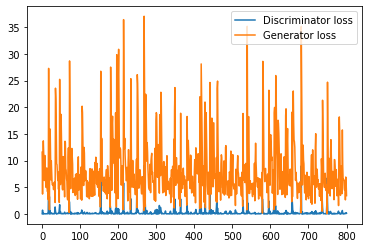

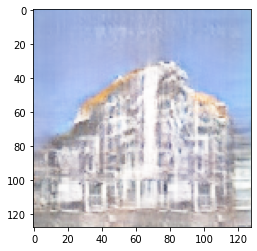

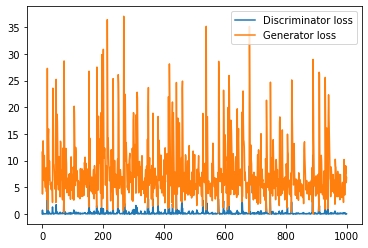

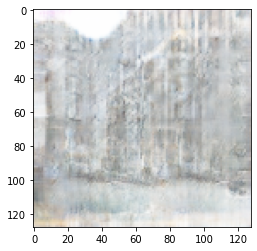

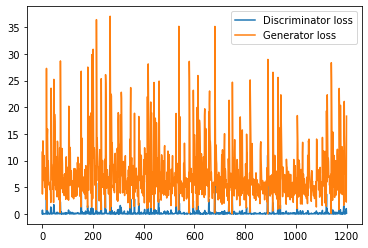

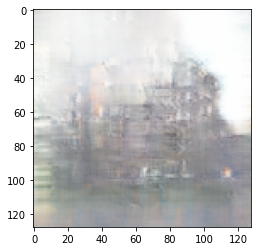

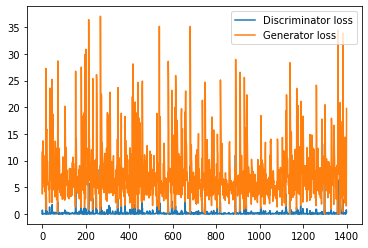

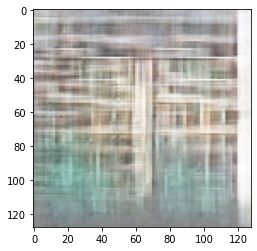

In [ ]:
train(image_generator, 1400, 200)

In [ ]:
# Сохранить веса модели генератора
generator_img_model.save_weights('/content/gdrive/MyDrive/City_gen/panel_house_11', save_format='tf')

In [ ]:
# Сохранить веса модели дискрименатора
discriminator_img_model.save_weights('/content/gdrive/MyDrive/City_gen/discr_panel_house_7', save_format='tf')

Генерация картинки

In [ ]:
def generate_data(latent_vector, generator):

    gen_imgs = generator(latent_vector)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

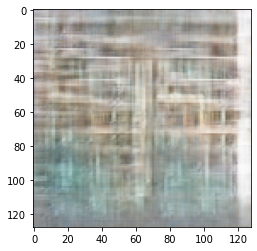

In [ ]:
z_vector = tf.random.normal([1, 100]) # случайный вектор

_ = plt.imshow(generate_data(z_vector, generator_img_model)[0])